In [5]:
"""Énergie renouvelable - Prédiction de la date de la prochaine production d’électricité de 1000 kWh par des panneaux solaires et à partir des prévisions météorologiques"""


import numpy as np
import pandas as pd
import datetime

weather = pd.read_csv('/Users/jl/Downloads/weather_in_Antwerp.csv', ';')
power_info = pd.read_csv('/Users/jl/Downloads/PV_Elec_Gas2.csv')

print(weather.head())
print(power_info.head())

   Unnamed: 0  clock   temp                    weather     wind humidity  \
0           0  00:20  11 °C             Mostly cloudy.  17 km/h      94%   
1           1  00:50  12 °C             Mostly cloudy.  17 km/h      88%   
2           2  01:50  12 °C                  Overcast.  19 km/h      88%   
3           3  02:20  12 °C             Partly cloudy.  17 km/h      88%   
4           4  02:50  12 °C  Sprinkles. Mostly cloudy.  15 km/h      88%   

   barometer visibility  year  month  day  
0  1011 mbar       5 km  2012      1    1  
1  1011 mbar        NaN  2012      1    1  
2  1011 mbar       9 km  2012      1    1  
3  1010 mbar        NaN  2012      1    1  
4  1010 mbar        NaN  2012      1    1  
   Unnamed: 0  cum_power  Elec_kW  Gas_mxm
0  2011-10-26        0.1     15.1      9.0
1  2011-10-27       10.2      7.4      9.2
2  2011-10-28       20.2      5.8      8.0
3  2011-10-29       29.6      4.9      6.6
4  2011-10-30       34.2     11.7      5.3


/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/1953499013.py:8: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  weather = pd.read_csv('/Users/jl/Downloads/weather_in_Antwerp.csv', ';')


In [6]:
# nettoyage de la table énergie solaire
power_info = power_info[['Unnamed: 0','cum_power']]
power_info = power_info.rename(columns= {'Unnamed: 0': 'date'})
print(power_info.head())

         date  cum_power
0  2011-10-26        0.1
1  2011-10-27       10.2
2  2011-10-28       20.2
3  2011-10-29       29.6
4  2011-10-30       34.2


In [7]:
# nous avons une colonne date en tant que dtype "object", pour la transformer en dtype datetime de pandas, nous faisons :
power_info.date = pd.to_datetime(power_info.date)
power_info.set_index(['date'], inplace=True)       # modifie l'indice
power_info.head()


,cum_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


In [8]:
# Correction de l'erreur de mesure
power_info = power_info.shift(periods=-1, freq='D', axis=0)   
                                                     
    


In [9]:
#Calculer la puissance journalière, car nous avons la puissance cumulée
temp = power_info.shift(periods=1, freq='D', axis=0)
power_info['day_power'] = power_info.loc[:, 'cum_power'] - temp.loc[:, 'cum_power']
power_info.drop(['cum_power'], axis=1, inplace=True)
power_info.day_power.iloc[0] = 5
power_info.head()

,day_power
date,
2011-10-25,5.0
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6


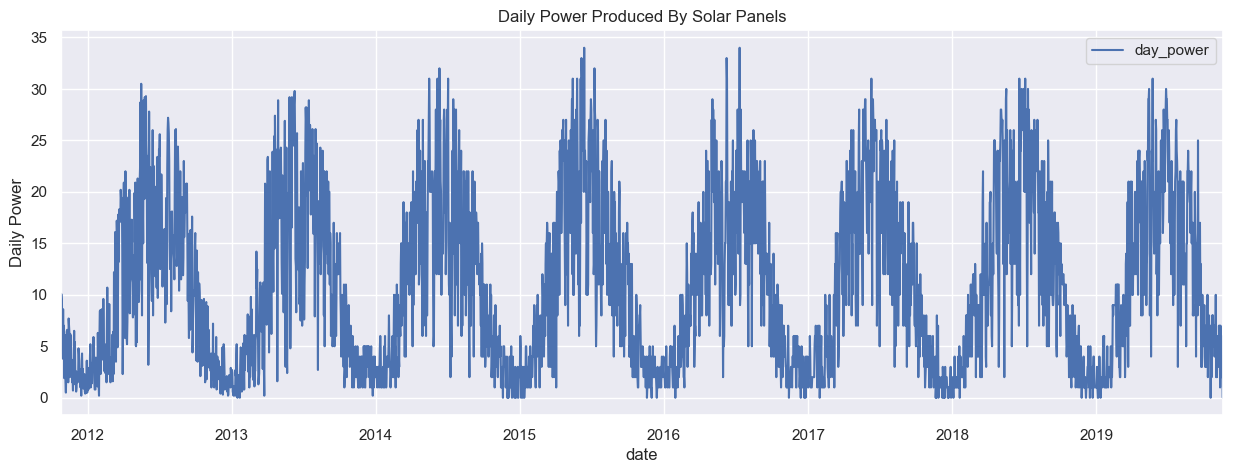

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
power_index= power_info.reset_index()
power_index.plot(kind='line', x='date', y='day_power', figsize=(15,5))

plt.title('Daily Power Produced By Solar Panels')
plt.ylabel('Daily Power')
plt.show()

In [11]:
# Nettoyage de la table météo

def clear_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h', '')
    return obj
def trans_from_objects(weather):
    weather.drop(['Unnamed: 0'], axis =1, inplace=True)
    
  
    #La déclaration d'essai est ici pour la météo à venir, 
    #car il n'y a pas de baromètre sur le site

    try:
        weather.barometer = weather.barometer.apply(lambda x: x.replace(' mbar', '') 
                                    if isinstance(x, str) else x).astype(float)
        weather.drop(['visibility'], axis =1, inplace=True)
    except AttributeError:
        pass
    
    weather.humidity = weather.humidity.apply(lambda x: x.replace('%', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.temp = weather.temp.apply(lambda x: x.replace('°C', '') 
                                    if isinstance(x, str) else x).astype(float)
    weather.wind = weather.wind.apply(clear_wind).astype(float)
    
    return weather

# transfert d'un cadre de données d'un type d'objets vers des nombres
weather_tran = trans_from_objects(weather)
weather_tran.head()




weather_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133669 entries, 0 to 133668
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   clock      133669 non-null  object 
 1   temp       133650 non-null  float64
 2   weather    133666 non-null  object 
 3   wind       133623 non-null  float64
 4   humidity   133321 non-null  float64
 5   barometer  133655 non-null  float64
 6   year       133669 non-null  int64  
 7   month      133669 non-null  int64  
 8   day        133669 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 9.2+ MB


In [12]:
# La colonne date 
def create_date(weather):    
    weather['date'] = weather.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day} {row.clock}', axis=1)
    weather.date = pd.to_datetime(weather.date)
    return weather.drop(['clock', 'year', 'month', 'day'], axis = 1)

weather_pretty = create_date(weather_tran)

print(weather_pretty.head())

   temp                    weather  wind  humidity  barometer  \
0  11.0             Mostly cloudy.  17.0      94.0     1011.0   
1  12.0             Mostly cloudy.  17.0      88.0     1011.0   
2  12.0                  Overcast.  19.0      88.0     1011.0   
3  12.0             Partly cloudy.  17.0      88.0     1010.0   
4  12.0  Sprinkles. Mostly cloudy.  15.0      88.0     1010.0   

                 date  
0 2012-01-01 00:20:00  
1 2012-01-01 00:50:00  
2 2012-01-01 01:50:00  
3 2012-01-01 02:20:00  
4 2012-01-01 02:50:00  


In [13]:
# prendre la moyenne journalière, ce qui nous permet d'avoir une météo quotidienne, vu que nous avons la puissance cumulée journalière et non horaire

def take_average_weather(weather, future = False):
    if future == False:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity', 'barometer',
                                              'date'])
    else:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity','date'])
    
    temp, wind, humidity, barometer, counter= [0]*5
    for i in range(len(weather)):
        if future == False:
            if (weather.loc[i, 'date'].time() ==datetime.time(0, 20)) and (i!=0):
                average_weather = average_weather.append({
                    'temp':temp/counter,
                    'wind':wind/counter,
                    'humidity':humidity/counter,
                    'barometer':barometer/counter,
                    'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                    'weather':weath
                }, ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5


            # Nous prendrons ici l'état de la météo à l'heure la plus puissante (15:20), car il n'est pas possible de prendre la moyenne. 
            if (weather.loc[i, 'date'].time()==datetime.time(15,20)):
                weath = weather.loc[i, 'weather']
        else:
            # ou i==len(weather)-1 , le dernier jour des données a été ajouté
            if ((weather.loc[i, 'date'].time() ==datetime.time(0, 0)) and (i!=0)) or (i==len(weather)-1):
                average_weather = average_weather.append({
                    'temp':temp/counter,
                    'wind':wind/counter,
                    'humidity':humidity/counter,
                    'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                    'weather':weath
                }, ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5


            #Ici, nous allons prendre l'état de la météo à l'heure la plus puissante (15:20),
            #car on ne peut pas prendre la moyenne avec des catégories.
            if (weather.loc[i, 'date'].time()==datetime.time(15,0)):
                weath = weather.loc[i, 'weather']
        counter += 1
        temp += weather.loc[i, 'temp']
        wind += weather.loc[i, 'wind']
        humidity += weather.loc[i, 'humidity']
        if future == False:
            barometer += weather.loc[i, 'barometer']
        
    return average_weather
average_weather = take_average_weather(weather_pretty)





def merge_weatherANDpower():
    dataset = average_weather.merge(power_info, on=['date'])
    return dataset.set_index('date')
final_dataset = merge_weatherANDpower()
final_dataset.head()

print(final_dataset.head())

/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average

                 temp                       weather       wind   humidity  \
date                                                                        
2012-01-01  12.333333                     Overcast.  21.333333  89.333333   
2012-01-02   7.787234             Scattered clouds.  17.212766  81.425532   
2012-01-03   8.208333              Light rain. Fog.  32.354167  78.229167   
2012-01-04   7.354167                Broken clouds.  26.375000  71.041667   
2012-01-05   8.292683  Rain showers. Broken clouds.  39.170732  77.804878   

              barometer  day_power  
date                                
2012-01-01  1007.866667        0.8  
2012-01-02  1009.170213        2.9  
2012-01-03  1007.916667        0.8  
2012-01-04  1012.687500        2.7  
2012-01-05   998.219512        1.6  


/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average

/Users/jl/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


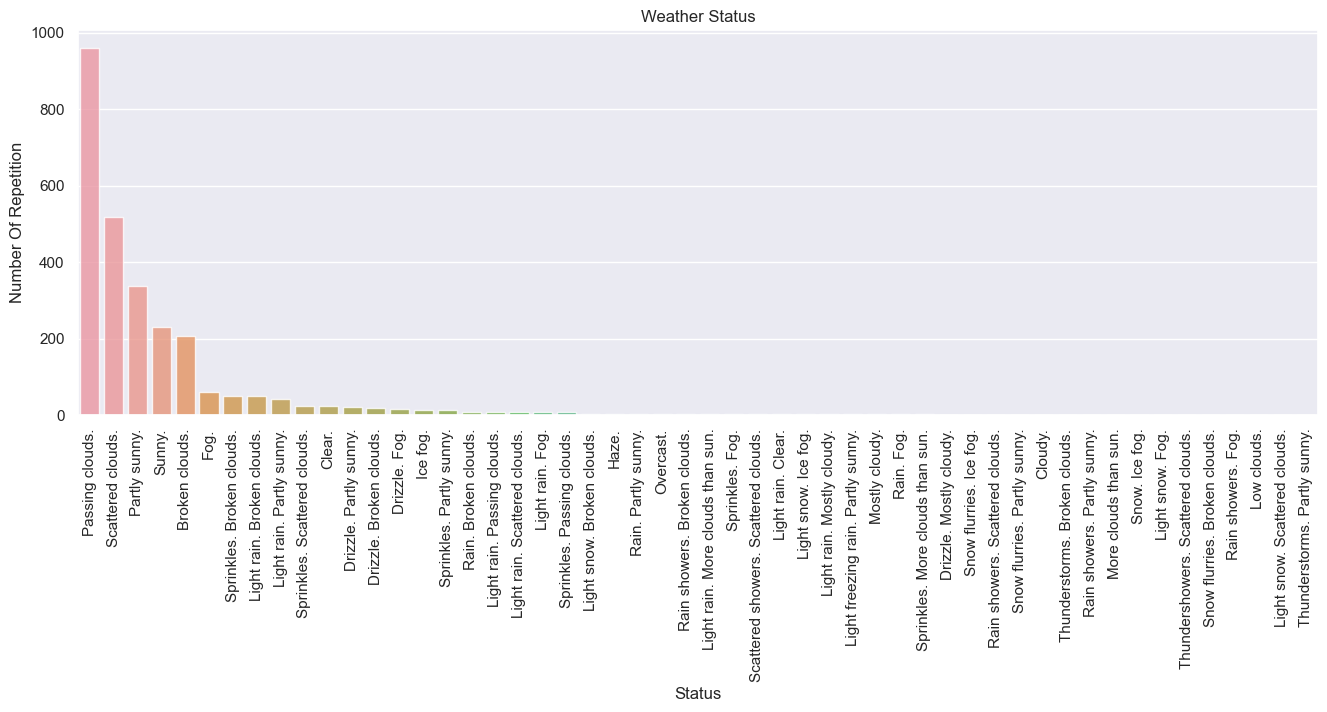

In [14]:
import seaborn as sns
weather_counts = final_dataset.weather.value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show() # Réduisons cette quantité d'informations redondantes

In [15]:
#necessaire pour pouvoir s'occuper de "loc"
final_dataset = final_dataset.reset_index()

def reduce_categories(weather):

    #Supprimer toutes les premières parties des statuts en deux parties et ne mettre en évidence que les catégories nécessaires. 
    #Pourquoi la première partie ? Parce que nous ne nous soucions pas du temps qu'il pleut ou qu'il neige, nous nous soucions davantage de l'état des nuages. 
    #l'état des nuages
    for i in range(len(weather)):
        weather_list = weather.loc[i, 'weather'].split('.')
        if len(weather_list) > 2:
            weather.loc[i,'weather'] = weather_list[1].strip()
        elif len(weather_list) ==2:
            weather.loc[i, 'weather'] = weather_list[0].strip()

    weather.weather = weather.weather.map({
        'Ice fog':'Fog',
        'Haze':'Fog',
        'Fog':'Fog',
        'Clear':'Sunny',
        'Sunny':'Sunny',
        'Broken clouds':'Scattered clouds',
        'Scattered clouds':'Scattered clouds',
        'Overcast':'Cloudy',
        'More clouds than sun':'Cloudy',
        'More sun than clouds':'Sunny',
        'Low clouds':'Cloudy',
        'Mostly cloudy':'Cloudy',
        'Cloudy':'Cloudy',
        'Passing clouds':'Passing clouds',
        'Partly sunny':'Partly sunny',
        'Mostly sunny':'Sunny'
    },na_action='ignore')
    return weather
final_dataset = reduce_categories(final_dataset)

#ramener l'index à la "date"
final_dataset.set_index('date', inplace=True)

/Users/jl/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


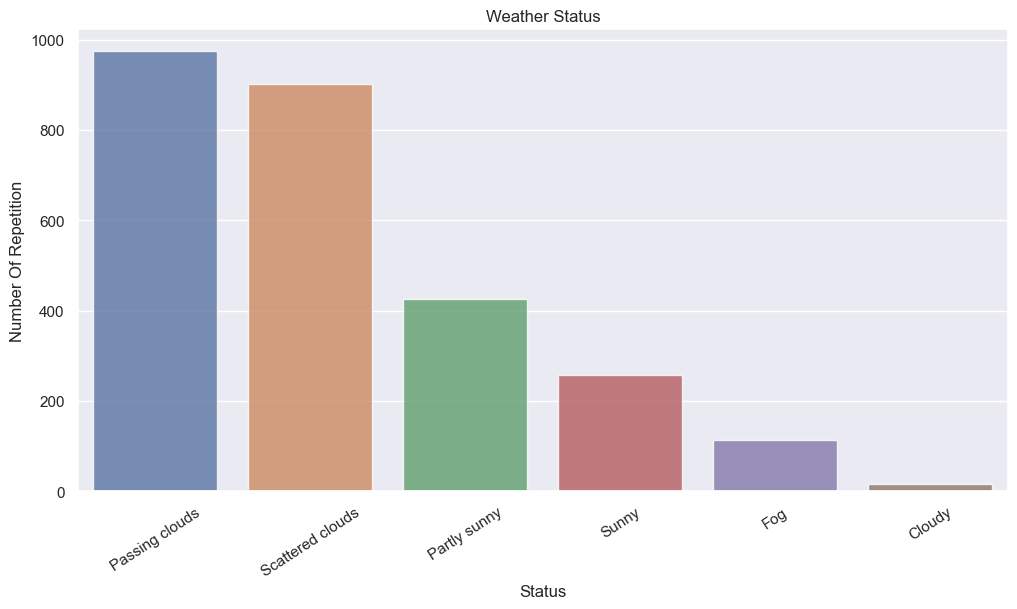

In [16]:
# Weather Status
from matplotlib import pyplot as plt
final_dataset.weather.value_counts()
weather_counts = final_dataset.weather.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=33)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [17]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2691 entries, 2012-01-01 to 2019-11-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       2686 non-null   float64
 1   weather    2691 non-null   object 
 2   wind       2679 non-null   float64
 3   humidity   2668 non-null   float64
 4   barometer  2686 non-null   float64
 5   day_power  2691 non-null   float64
dtypes: float64(5), object(1)
memory usage: 147.2+ KB


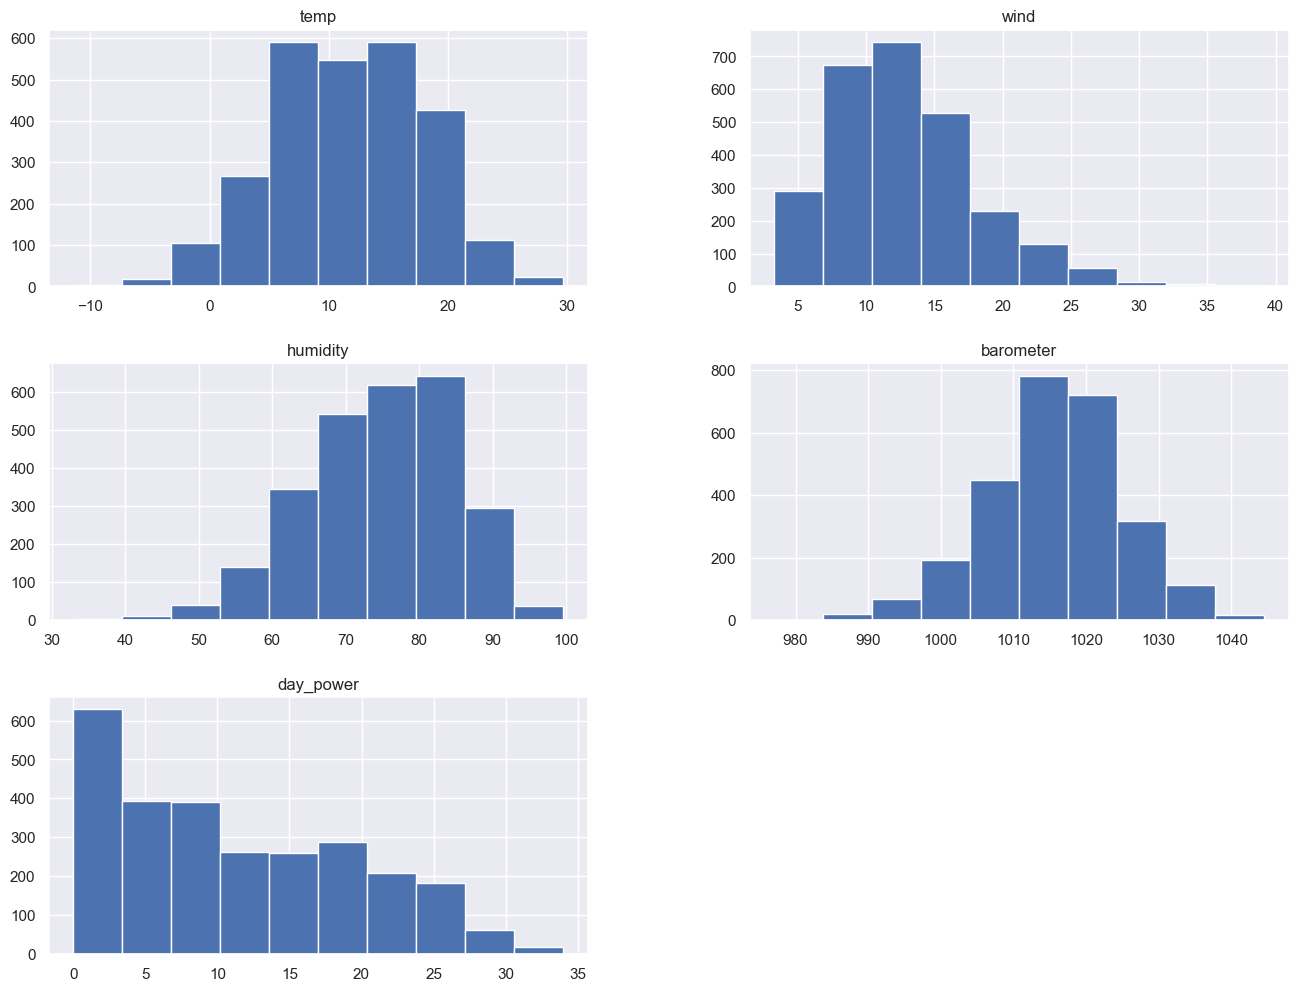

In [18]:
final_dataset.hist(figsize=(16,12))
plt.show()

In [19]:
# entrainement du modele de ML

from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(final_dataset, test_size=0.2, 
                                                   random_state=42) 
df = train_set.copy() 
df.describe() 


,temp,wind,humidity,barometer,day_power
count,2148.000000,2143.000000,2133.000000,2148.000000,2152.000000
mean,11.588496,12.862733,75.117709,1015.686936,11.225232
std,6.391742,5.296349,10.140503,9.361720,8.286647
min,-11.437500,3.250000,32.914894,977.041667,0.000000
25%,6.768466,9.000000,68.000000,1010.037123,4.000000
50%,11.536791,12.127660,76.187500,1016.010417,10.000000
75%,16.605757,15.779034,82.854167,1021.957668,18.000000
max,29.680851,39.170732,99.625000,1044.541667,34.000000


In [20]:
df.corr() 

,temp,wind,humidity,barometer,day_power
temp,1.000000,-0.116808,-0.447690,-0.029543,0.628767
wind,-0.116808,1.000000,-0.001582,-0.366384,-0.216053
humidity,-0.447690,-0.001582,1.000000,-0.145609,-0.742221
barometer,-0.029543,-0.366384,-0.145609,1.000000,0.178460
day_power,0.628767,-0.216053,-0.742221,0.178460,1.000000


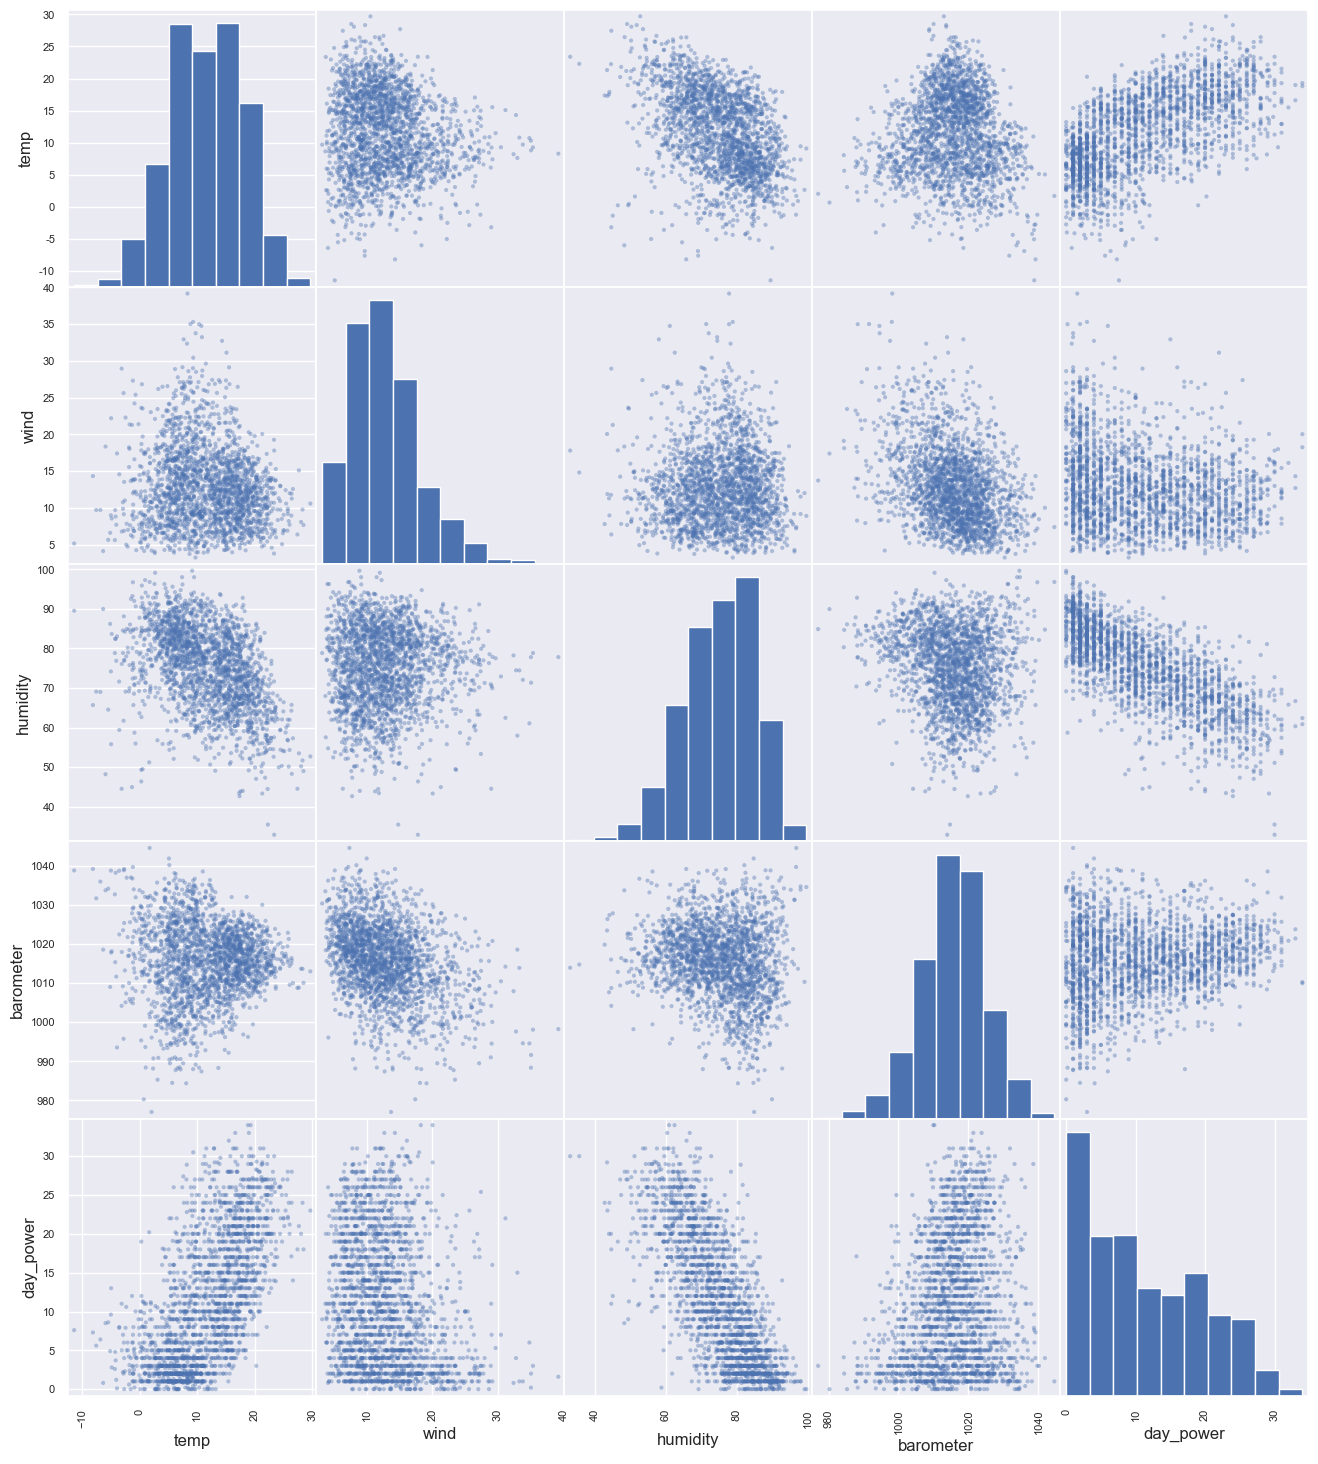

In [21]:
from pandas.plotting import scatter_matrix 
scatter_matrix(df, figsize=(16,18), alpha=0.4) 
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


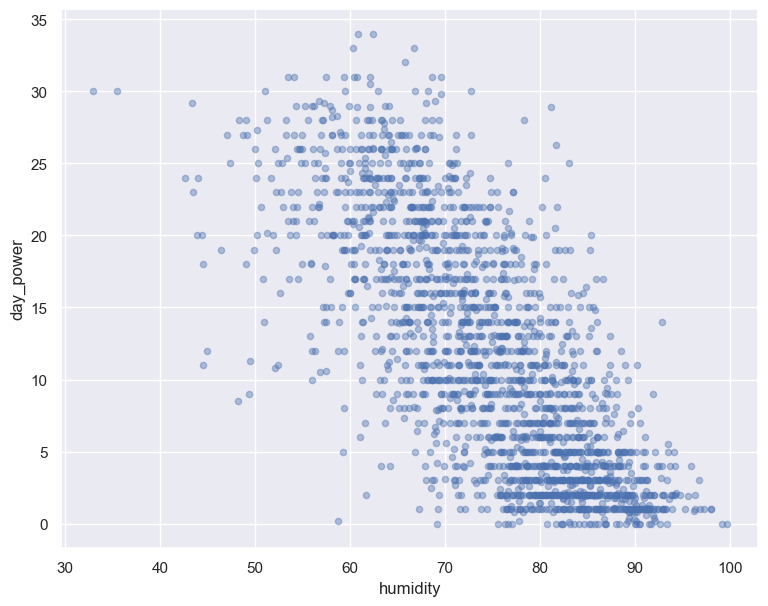

In [22]:
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


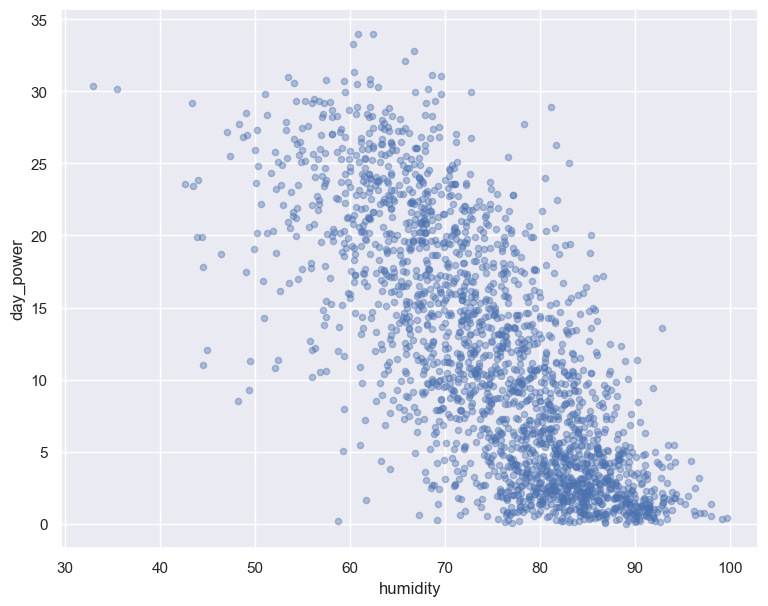

In [23]:
# suppression des anomalies
import random
df.day_power = df.day_power.apply(lambda x: x+random.randint(0,50)/100 if x==0 else x)
for i in range(1,34):
    df.day_power = df.day_power.apply(lambda x: x+random.randint(-50,50)/100 if x==i else x)
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4) 
plt.show()

In [24]:
# Comme nous disposons de données (que nous voulons prédire), sans colonne de baromètre
features = df.drop(['day_power', 'barometer'], axis=1) 
columns=features.columns 
labels = df['day_power'].copy() 
features.head() 

,temp,weather,wind,humidity
date,,,,
2016-04-13,9.953488,Passing clouds,7.790698,71.604651
2019-06-19,19.739130,Sunny,10.347826,78.543478
2018-05-15,18.777778,Passing clouds,11.400000,59.000000
2012-03-01,7.750000,Fog,5.791667,91.125000
2019-09-17,14.833333,Scattered clouds,11.395833,66.187500


In [25]:
num_attr = list(features.drop(['weather'],axis=1)) 
cat_attr = ['weather'] 

In [26]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler 


num_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()) 
]) 

cat_pipeline = Pipeline([ 
    ('encoder', OneHotEncoder()) 
]) 

full_pipeline = ColumnTransformer([ 
    ('num_pipeline', num_pipeline, num_attr),
    ('cat_pipeline', cat_pipeline, cat_attr) 
]) 

In [27]:
prepared_features = full_pipeline.fit_transform(features) 

In [28]:
import numpy as np 

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import cross_val_score  

lin_reg = LinearRegression() 
lin_reg.fit(prepared_features, labels) 
y_predicted = lin_reg.predict(prepared_features) 
scores = cross_val_score(lin_reg, prepared_features, labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.567987210642631

0.20357687176607633

In [29]:
test = test_set.copy()
test_features = test.drop(['day_power', 'barometer'], axis=1) 
test_labels = test['day_power'].copy() 

In [30]:
prepared_test = full_pipeline.transform(test_features) 
test_predicted = lin_reg.predict(prepared_test)

In [31]:
scores = cross_val_score(lin_reg, prepared_test, test_labels, 
                         scoring='neg_mean_squared_error', cv=10) 
scores=np.sqrt(-scores) 
display(scores.mean()) 
scores.std() 

4.40547528841805

0.31244032346052764

In [32]:
# Visualisation de la différence entre les valeurs prédites et réelles de la puissance journalière pour l'ensemble des tests

avg=[]
labels_avg = []
for i in range(len(test_labels)):
    avg.append(test_labels[i])
    if i % 40 == 0:
        labels_avg.append(np.array(avg).mean())
        avg.clear()
avg=[]
pred_avg = []
for i in range(len(test_predicted)):
    avg.append(test_predicted[i])
    if i % 40 == 0:
        pred_avg.append(np.array(avg).mean())
        avg.clear()

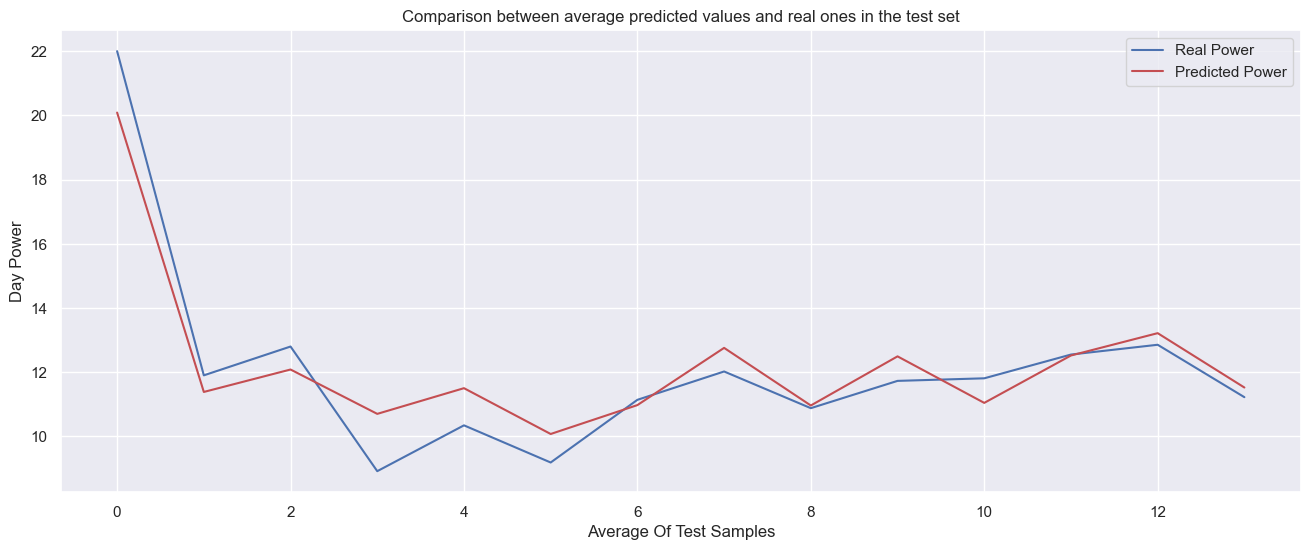

In [33]:
plt.figure(figsize=(16,6))
plt.plot(range(len(labels_avg)), labels_avg)
plt.plot(range(len(pred_avg)), pred_avg, 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

In [34]:
weather_future= pd.read_csv('/Users/jl/Downloads/weather_in_Antwerp_future2.csv', ';')

/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/4081056701.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  weather_future= pd.read_csv('/Users/jl/Downloads/weather_in_Antwerp_future2.csv', ';')


In [35]:
def predict_future_data(data):
    tran_fut = trans_from_objects(data)
    tran_fut = create_date(tran_fut)
    avg_fut = take_average_weather(tran_fut, future=True)
    red_fut = reduce_categories(avg_fut)
    red_fut = red_fut.set_index('date')
    prepared_future = full_pipeline.transform(red_fut)
    return red_fut.index, lin_reg.predict(prepared_future)

date, predicted_data = predict_future_data(weather_future)

/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
/var/folders/r5/sycktgpj0ln8vbwphhbh5mb00000gn/T/ipykernel_7692/716732173.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average

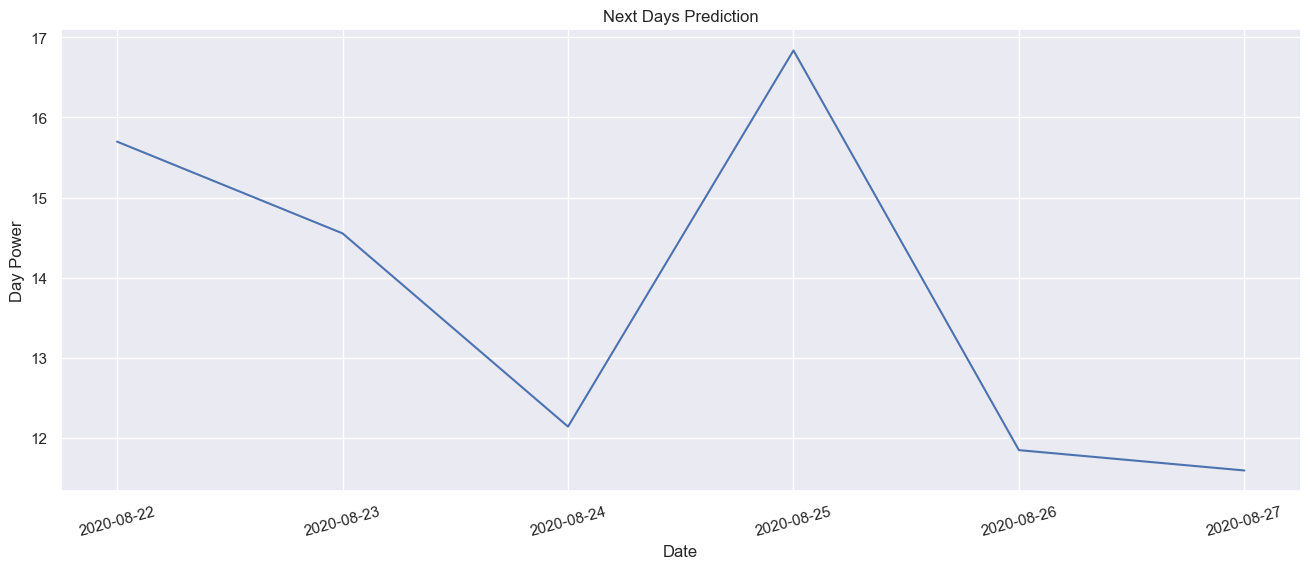

In [36]:
# prédiction pour les jours suivants
plt.figure(figsize=(16,6))
plt.plot(date,predicted_data)
plt.title('Next Days Prediction')
plt.ylabel('Day Power')
plt.xlabel('Date')
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xticks(rotation=15)
plt.show()